In [ ]:
import os
import torch

os.environ["TORCH"] = torch.__version__
print(torch.__version__)

1.12.1+cu113


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 2.7 MB/s 
     |████████████████████████████████| 3.5 MB 2.8 MB/s 


In [ ]:
!nvidia-smi

Thu Nov  3 15:37:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
import argparse
from sklearn.metrics import roc_auc_score, f1_score

import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
from torch_geometric.utils import structured_negative_sampling, subgraph, k_hop_subgraph


In [ ]:
data_path = "pytorch_geometric_version/data/"
# data_path = '/content/drive/MyDrive/AI_Naver_PTIT/KGCN/torch/data/'


class DataLoader:
    """
    Data Loader class which makes dataset for training / knowledge graph dictionary
    """

    def __init__(self, data):
        self.cfg = {
            "movie": {
                "item2id_path": data_path + "movie/item_index2entity_id.txt",
                "kg_path": data_path + "movie/kg.txt",
                "rating_path": data_path + "movie/ratings.csv",
                "rating_sep": ",",
                "threshold": 4.0,
            },
            "music": {
                "item2id_path": data_path + "music/item_index2entity_id.txt",
                "kg_path": data_path + "music/kg.txt",
                "rating_path": data_path + "music/user_artists.dat",
                "rating_sep": "\t",
                "threshold": 0.0,
            },
            'kkbox': {
                'item2id_path': data_path + "KKBOX_data/item_index2entity_id.txt",
                'kg_path': data_path + "KKBOX_data/kg.txt",
                'rating_path': data_path + "KKBOX_data/user_item.dat",
                'rating_sep': '\t',
                'threshold': 0.0
            },
            'ml100k': {
                'item2id_path': data_path + "ML100K/item_index2entity_id.txt",
                'kg_path': data_path + "ML100K/kg.txt",
                'rating_path': data_path + "ML100K/user_item.dat",
                'rating_sep': '\t',
                'threshold': 0.0
            }
        }
        self.data = data

        df_item2id = pd.read_csv(
            self.cfg[data]["item2id_path"], sep="\t", header=None, names=["item", "id"]
        )
        df_kg = pd.read_csv(
            self.cfg[data]["kg_path"],
            sep="\t",
            header=None,
            names=["head", "relation", "tail"],
        )
        df_rating = pd.read_csv(
            self.cfg[data]["rating_path"],
            sep=self.cfg[data]["rating_sep"],
            names=["userID", "itemID", "rating"],
            skiprows=1,
        )

        # df_rating['itemID'] and df_item2id['item'] both represents old entity ID
        df_rating = df_rating[df_rating["itemID"].isin(df_item2id["item"])]
        df_rating.reset_index(inplace=True, drop=True)

        self.df_item2id = df_item2id
        self.df_kg = df_kg
        self.df_rating = df_rating

        self.user_encoder = LabelEncoder()
        self.entity_encoder = LabelEncoder()
        self.relation_encoder = LabelEncoder()

        self._encoding()

    def _encoding(self):
        """
        Fit each label encoder and encode knowledge graph
        """
        self.user_encoder.fit(self.df_rating["userID"])
        # df_item2id['id'] and df_kg[['head', 'tail']] represents new entity ID
        self.entity_encoder.fit(
            pd.concat([self.df_item2id["id"], self.df_kg["head"], self.df_kg["tail"]])
        )
        self.relation_encoder.fit(self.df_kg["relation"])

        # encode df_kg
        self.df_kg["head"] = self.entity_encoder.transform(self.df_kg["head"])
        self.df_kg["tail"] = self.entity_encoder.transform(self.df_kg["tail"])
        self.df_kg["relation"] = self.relation_encoder.transform(self.df_kg["relation"])

    def _build_dataset(self):
        """
        Build dataset for training (rating data)
        It contains negative sampling process
        """
        print("Build dataset dataframe ...", end=" ")
        # df_rating update
        df_dataset = pd.DataFrame()
        df_dataset["userID"] = self.user_encoder.transform(self.df_rating["userID"])

        # update to new id
        item2id_dict = dict(zip(self.df_item2id["item"], self.df_item2id["id"]))
        self.df_rating["itemID"] = self.df_rating["itemID"].apply(
            lambda x: item2id_dict[x]
        )
        df_dataset["itemID"] = self.entity_encoder.transform(self.df_rating["itemID"])
        df_dataset["label"] = self.df_rating["rating"].apply(
            lambda x: 0 if x < self.cfg[self.data]["threshold"] else 1
        )

        # negative sampling
        df_dataset = df_dataset[df_dataset["label"] == 1]
        # df_dataset requires columns to have new entity ID
        full_item_set = set(range(len(self.entity_encoder.classes_)))
        user_list = []
        item_list = []
        label_list = []
        for user, group in df_dataset.groupby(["userID"]):
            item_set = set(group["itemID"])
            negative_set = full_item_set - item_set
            negative_sampled = random.sample(negative_set, len(item_set))
            user_list.extend([user] * len(negative_sampled))
            item_list.extend(negative_sampled)
            label_list.extend([0] * len(negative_sampled))
        negative = pd.DataFrame(
            {"userID": user_list, "itemID": item_list, "label": label_list}
        )
        df_dataset = pd.concat([df_dataset, negative])

        df_dataset = df_dataset.sample(frac=1, replace=False, random_state=999)
        df_dataset.reset_index(inplace=True, drop=True)
        print("Done")
        return df_dataset

    def _construct_kg(self):
        """
        Construct knowledge graph
        Knowledge graph is dictionary form
        'head': [(relation, tail), ...]
        """
        print("Construct knowledge graph ...", end=" ")
        kg = dict()
        for i in range(len(self.df_kg)):
            head = self.df_kg.iloc[i]["head"]
            relation = self.df_kg.iloc[i]["relation"]
            tail = self.df_kg.iloc[i]["tail"]
            if head in kg:
                kg[head].append((relation, tail))
            else:
                kg[head] = [(relation, tail)]
            if tail in kg:
                kg[tail].append((relation, head))
            else:
                kg[tail] = [(relation, head)]
        print("Done")
        return kg

    def load_dataset(self):
        return self._build_dataset()

    def load_kg(self):
        return self._construct_kg()

    def get_encoders(self):
        return (self.user_encoder, self.entity_encoder, self.relation_encoder)

    def get_num(self):
        return (
            len(self.user_encoder.classes_),
            len(self.entity_encoder.classes_),
            len(self.relation_encoder.classes_),
        )

In [ ]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='music', help='which dataset to use')
# parser.add_argument('--n_epochs', type=int, default=25, help='the number of epochs')
# parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
# parser.add_argument('--batch_size', type=int, default=32, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])


In [ ]:
# parser = argparse.ArgumentParser()

# parser.add_argument("--dataset", type=str, default="movie", help="which dataset to use")
# parser.add_argument("--n_epochs", type=int, default=1, help="the number of epochs")
# parser.add_argument(
#     "--dim", type=int, default=32, help="dimension of user and entity embeddings"
# )
# parser.add_argument("--batch_size", type=int, default=65536, help="batch size")
# parser.add_argument(
#     "--l2_weight", type=float, default=1e-7, help="weight of l2 regularization"
# )
# parser.add_argument("--lr", type=float, default=2e-2, help="learning rate")
# parser.add_argument("--ratio", type=float, default=0.6, help="size of training dataset")

# args = parser.parse_args([])

In [ ]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='kkbox', help='which dataset to use')
# parser.add_argument('--n_epochs', type=int, default=5, help='the number of epochs')
# parser.add_argument('--dim', type=int, default=32, help='dimension of user and entity embeddings')
# parser.add_argument('--batch_size', type=int, default=32768, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-7, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=2e-2, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])

In [ ]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='ml100k', help='which dataset to use')
# parser.add_argument('--n_epochs', type=int, default=5, help='the number of epochs')
# parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
# parser.add_argument('--batch_size', type=int, default=16, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])

In [ ]:
# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset


Construct knowledge graph ... Done
Build dataset dataframe ... Done


,userID,itemID,label
0,602,3,1
1,314,2,1
2,8404,34655,0
3,462,3,1
4,12826,2,1
...,...,...,...
14947307,7348,4,1
14947308,721,0,1
14947309,90,2,1
14947310,249,2,1


In [ ]:
# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]["userID"])
        item_id = np.array(self.df.iloc[idx]["itemID"])
        label = np.array(self.df.iloc[idx]["label"], dtype=np.float32)
        return user_id, item_id, label

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(
    df_dataset,
    df_dataset["label"],
    test_size=1 - args.ratio,
    shuffle=False,
    random_state=999,
)
x_test, _, y_test, _ = train_test_split(
    x_test, y_test, test_size=0.5, shuffle=False, random_state=999
)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

### model v1 use learning weight of gcn to reduce the dimension at forward

In [ ]:
import sys
import torch
import torch.nn.functional as F
import random
import numpy as np
import copy
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear, Parameter


class vanilla_gcn_aug_v1(MessagePassing):
    def __init__(self, num_user, num_ent, num_rel, kg, args, device):
        super(vanilla_gcn_aug_v1, self).__init__(aggr="add")
        self.num_user = num_user
        self.num_ent = num_ent
        self.num_rel = num_rel
        self.batch_size = args.batch_size
        # self.max_neighbor = 600
        self.max_neighbor = 20
        self.kg = kg
        self.device = device
        self._gen_adj()
        # entity augment
        self.dim_aug = self.num_ent + self.num_rel
        self.ent_aug = torch.nn.Embedding.from_pretrained(
            torch.tensor(self.list_ent_aug).type(torch.FloatTensor), freeze=True
        )
        # entity hidden
        self.dim_hid = args.dim
        self.ent_hid = torch.nn.Embedding(num_ent, self.dim_hid)
        # user emb
        self.usr = torch.nn.Embedding(num_user, self.dim_hid)
        # linear transform
        self.lin = Linear(self.dim_hid + self.dim_aug, self.dim_hid, bias=False)
        self.bias = Parameter(torch.Tensor(self.dim_hid))
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def _gen_adj(self):
        """
        Generate adjacency matrix for entities and relations
        Only cares about fixed number of samples
        """

        self.list_id_neighbor = np.full((self.num_ent, self.max_neighbor), -1)
        self.list_ent_aug = np.full((self.num_ent, self.num_ent + self.num_rel), -1)

        for e in self.kg:
            if len(self.kg[e]) >= self.max_neighbor:
                neighbors_to_sparse_coo_tensor = random.sample(
                    self.kg[e], self.max_neighbor
                )
            else:
                neighbors_to_sparse_coo_tensor = random.choices(
                    self.kg[e], k=self.max_neighbor
                )
            self.list_id_neighbor[e] = [
                ent for _, ent in neighbors_to_sparse_coo_tensor
            ]

            # get all neighbors
            id_neighbor = [ent for _, ent in self.kg[e]]
            id_neighbor.append(e)
            id_edge = [rel for rel, _ in self.kg[e]]

            # count
            id_neighbor_count = np.bincount(id_neighbor)
            id_neighbor_count = np.pad(
                id_neighbor_count,
                (0, self.num_ent - len(id_neighbor_count)),
                "constant",
                constant_values=(0),
            )
            id_edge_count = np.bincount(id_edge)
            id_edge_count = np.pad(
                id_edge_count,
                (0, self.num_rel - len(id_edge_count)),
                "constant",
                constant_values=(0),
            )

            # concat
            self.list_ent_aug[e] = np.concatenate((id_neighbor_count, id_edge_count))

    def forward(self, user_indices, item_indices, device):

        # src = np.concatenate((self.list_id_neighbor[item_indices].flatten(), item_indices))
        # target = np.concatenate((np.array(np.repeat(item_indices, self.n_neighbor)), item_indices))

        src = np.concatenate(
            (self.list_id_neighbor[item_indices.cpu()].flatten(), item_indices.cpu())
        )
        target = np.concatenate(
            (
                np.array(np.repeat(item_indices.cpu(), self.max_neighbor)),
                item_indices.cpu(),
            )
        )

        list_node_id_1_hop_item = np.unique(np.array([src, target]).T, axis=0)
        list_node_id_1_hop_item = list_node_id_1_hop_item.T
        list_node_id_1_hop_item = torch.tensor(list_node_id_1_hop_item).to(device)

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index = list_node_id_1_hop_item
        # edge_index = list_node_id_1_hop_item

        # Step 2: Linearly transform node feature matrix.
        x = torch.cat((self.ent_hid.weight, self.ent_aug.weight), 1)
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        item_embs_all = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        item_embs_all += self.bias

        user_embeddings = self.usr(user_indices)

        item_embs = item_embs_all[item_indices]

        scores = (item_embs * user_embeddings).sum(dim=-1)

        return torch.sigmoid(scores)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

### model v2 use random projection to reduce the dimension at forward

In [ ]:
import sys
import torch
import torch.nn.functional as F
import random
import numpy as np
import copy
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear, Parameter
from sklearn.random_projection import GaussianRandomProjection


class vanilla_gcn_aug_v2(MessagePassing):
    def __init__(self, num_user, num_ent, num_rel, kg, args, device):
        super(vanilla_gcn_aug_v2, self).__init__(aggr="add")
        self.num_user = num_user
        self.num_ent = num_ent
        self.num_rel = num_rel
        self.batch_size = args.batch_size
        # self.max_neighbor = 600
        self.max_neighbor = 20
        self.kg = kg
        self.device = device
        self._gen_adj()

        # entity augment
        self.dim_aug = self.num_ent + self.num_rel
        self.ent_aug = torch.nn.Embedding.from_pretrained(
            torch.tensor(self.list_ent_aug).type(torch.FloatTensor), freeze=True
        )

        # entity hidden
        self.dim_hid = args.dim
        self.ent_hid = torch.nn.Embedding(num_ent, self.dim_hid)

        # user emb
        self.usr = torch.nn.Embedding(num_user, self.dim_hid)

        # random projection
        random_projector = GaussianRandomProjection(n_components="auto", eps=0.2)
        random_projector.fit(
            np.full((self.num_ent, self.dim_hid + self.dim_aug), 0)
        )  # simple create a matrix with shape like: torch.cat((self.ent_hid.weight, self.ent_aug.weight), 1)
        num_output_random_projector = random_projector.components_.shape[
            0
        ]  # (numOutFeature, numOrginFeature)
        self.random_projector = (
            torch.tensor(np.linalg.pinv(random_projector.components_))
            .type(torch.FloatTensor)
            .to(device)
        )  # get matrix random projection and transform to torch tensor

        # linear transform
        self.lin = Linear(num_output_random_projector, self.dim_hid, bias=False)
        self.bias = Parameter(torch.Tensor(self.dim_hid))
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def _gen_adj(self):
        """
        Generate adjacency matrix for entities and relations
        Only cares about fixed number of samples
        """

        self.list_id_neighbor = np.full((self.num_ent, self.max_neighbor), -1)
        self.list_ent_aug = np.full((self.num_ent, self.num_ent + self.num_rel), -1)

        for e in self.kg:
            if len(self.kg[e]) >= self.max_neighbor:
                neighbors_to_sparse_coo_tensor = random.sample(
                    self.kg[e], self.max_neighbor
                )
            else:
                neighbors_to_sparse_coo_tensor = random.choices(
                    self.kg[e], k=self.max_neighbor
                )
            self.list_id_neighbor[e] = [
                ent for _, ent in neighbors_to_sparse_coo_tensor
            ]

            # get all neighbors
            id_neighbor = [ent for _, ent in self.kg[e]]
            id_neighbor.append(e)
            id_edge = [rel for rel, _ in self.kg[e]]

            # count
            id_neighbor_count = np.bincount(id_neighbor)
            id_neighbor_count = np.pad(
                id_neighbor_count,
                (0, self.num_ent - len(id_neighbor_count)),
                "constant",
                constant_values=(0),
            )
            id_edge_count = np.bincount(id_edge)
            id_edge_count = np.pad(
                id_edge_count,
                (0, self.num_rel - len(id_edge_count)),
                "constant",
                constant_values=(0),
            )

            # concat
            self.list_ent_aug[e] = np.concatenate((id_neighbor_count, id_edge_count))

    def forward(self, user_indices, item_indices, device):

        src = np.concatenate(
            (self.list_id_neighbor[item_indices.cpu()].flatten(), item_indices.cpu())
        )
        target = np.concatenate(
            (
                np.array(np.repeat(item_indices.cpu(), self.max_neighbor)),
                item_indices.cpu(),
            )
        )

        list_node_id_1_hop_item = np.unique(np.array([src, target]).T, axis=0)
        list_node_id_1_hop_item = list_node_id_1_hop_item.T
        list_node_id_1_hop_item = torch.tensor(list_node_id_1_hop_item).to(device)

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index = list_node_id_1_hop_item

        # Step 2: Linearly transform node feature matrix.

        # Gaussian Random Projection
        x = torch.cat((self.ent_hid.weight, self.ent_aug.weight), 1)
        x = torch.matmul(x, self.random_projector)
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        item_embs_all = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        item_embs_all += self.bias

        user_embeddings = self.usr(user_indices)

        item_embs = item_embs_all[item_indices]

        scores = (item_embs * user_embeddings).sum(dim=-1)

        return torch.sigmoid(scores)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

### model v3 use random projection and learning weight to reduce the dimension at init

In [ ]:
import sys
import torch
import torch.nn.functional as F
import random
import numpy as np
import copy
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear, Parameter
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from scipy.sparse import csr_matrix


class vanilla_gcn_aug_v3(MessagePassing):
    def __init__(self, num_user, num_ent, num_rel, kg, args, device):
        super(vanilla_gcn_aug_v3, self).__init__(aggr="add")
        self.num_user = num_user
        self.num_ent = num_ent
        self.num_rel = num_rel
        self.batch_size = args.batch_size
        self.max_neighbor = 600
        # self.max_neighbor = 20
        self.kg = kg
        self.device = device
        self._gen_adj()

        # define random projection
        # random_projector = GaussianRandomProjection(n_components='auto', eps=0.2)
        random_projector = SparseRandomProjection(n_components="auto", eps=0.2)

        # entity augment
        self.dim_aug = self.num_ent + self.num_rel
        ent_aug = random_projector.fit_transform(self.list_ent_aug)
        num_output_random_projector = random_projector.components_.shape[0]
        print(num_output_random_projector)
        print(random_projector.components_.shape)
        self.ent_aug = torch.nn.Embedding.from_pretrained(
            torch.tensor(ent_aug.toarray()).type(torch.FloatTensor), freeze=True
        )

        # entity hidden
        self.dim_hid = args.dim
        self.ent_hid = torch.nn.Embedding(num_ent, self.dim_hid)

        # user emb
        self.usr = torch.nn.Embedding(num_user, self.dim_hid)

        # linear transform
        self.lin = Linear(
            num_output_random_projector + self.dim_hid, self.dim_hid, bias=False
        )
        self.bias = Parameter(torch.Tensor(self.dim_hid))
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def _gen_adj(self):
        """
        Generate adjacency matrix for entities and relations
        Only cares about fixed number of samples
        """
        self.list_id_neighbor = np.full((self.num_ent, self.max_neighbor), -1)
        # self.list_ent_aug = np.full((self.num_ent, self.num_ent + self.num_rel), -1)
        row = []
        col = []
        data = []

        for e in self.kg:
            if len(self.kg[e]) >= self.max_neighbor:
                neighbors_to_sparse_coo_tensor = random.sample(
                    self.kg[e], self.max_neighbor
                )
            else:
                neighbors_to_sparse_coo_tensor = random.choices(
                    self.kg[e], k=self.max_neighbor
                )
            self.list_id_neighbor[e] = [
                ent for _, ent in neighbors_to_sparse_coo_tensor
            ]

            ent_list_tmp = []
            rel_list_tmp = []
            # print("kg[e]")
            # print(kg[e])
            for rel, ent in self.kg[e]:
                ent_list_tmp.append(ent)
                rel_list_tmp.append(rel)

            for ent in set(ent_list_tmp):
                row.append(e)
                col.append(ent)
                data.append(ent_list_tmp.count(ent))
            for rel in set(rel_list_tmp):
                row.append(e)
                col.append(self.num_ent + rel)
                data.append(rel_list_tmp.count(rel))

        self.list_ent_aug = csr_matrix(
            (data, (row, col)), shape=(self.num_ent, self.num_ent + self.num_rel)
        )

    def forward(self, user_indices, item_indices, device):

        src = np.concatenate(
            (self.list_id_neighbor[item_indices.cpu()].flatten(), item_indices.cpu())
        )
        target = np.concatenate(
            (
                np.array(np.repeat(item_indices.cpu(), self.max_neighbor)),
                item_indices.cpu(),
            )
        )

        list_node_id_1_hop_item = np.unique(np.array([src, target]).T, axis=0)
        list_node_id_1_hop_item = list_node_id_1_hop_item.T
        list_node_id_1_hop_item = torch.tensor(list_node_id_1_hop_item).to(device)

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index = list_node_id_1_hop_item

        # Step 2: Linearly transform node feature matrix.

        # Gaussian Random Projection
        x = torch.cat((self.ent_hid.weight, self.ent_aug.weight), 1)
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        item_embs_all = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        item_embs_all += self.bias

        user_embeddings = self.usr(user_indices)

        item_embs = item_embs_all[item_indices]

        scores = (item_embs * user_embeddings).sum(dim=-1)

        return torch.sigmoid(scores)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

## train

In [ ]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = vanilla_gcn_aug_v3(num_user, num_entity, num_relation, kg, args, device).to(
    device
)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print("device: ", device)

1
2
3
2662
(2662, 102601)
device:  cuda


In [ ]:
loss_list = []
test_loss_list = []
auc_score_list = []
f1_score_list = []

import time

start_train = time.time()
print("start_train:", start_train)

for epoch in range(args.n_epochs):
    running_loss = 0.0

    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = (
            user_ids.to(device),
            item_ids.to(device),
            labels.to(device),
        )
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids, device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # print train loss per every epoch
    print("[Epoch {}]".format(epoch + 1))
    print("train_loss: ".format(epoch + 1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))

    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        total_f1 = 0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = (
                user_ids.to(device),
                item_ids.to(device),
                labels.to(device),
            )
            outputs = net(user_ids, item_ids, device)
            test_loss += criterion(outputs, labels).item()
            outputs = outputs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            total_roc += roc_auc_score(labels, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            total_f1 += f1_score(labels, outputs)

        print("test_loss: ".format(epoch + 1), test_loss / len(test_loader))
        print("test_auc: ".format(epoch + 1), total_roc / len(test_loader))
        print("test_f1: ".format(epoch + 1), total_f1 / len(test_loader))
        print("--------------------------------")
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))
        f1_score_list.append(total_f1 / len(test_loader))

end_train = time.time()
print("end_train:", end_train)
print("end_train - start_train:", end_train - start_train)

start_train: 1667490098.1362097
[Epoch 1]
train_loss:  0.0765174658081909
test_loss:  0.004492022648818143
test_auc:  0.9980083262318239
test_f1:  0.9994990055350182
--------------------------------
end_train: 1667499220.9527242
end_train - start_train: 9122.816514492035


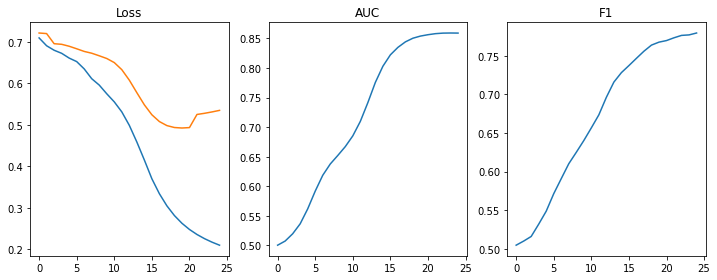

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.plot(loss_list)
ax1.plot(test_loss_list)
ax1.set_title("Loss")
ax2.plot(auc_score_list)
ax2.set_title("AUC")
ax3.plot(f1_score_list)
ax3.set_title("F1")

plt.tight_layout()